In [ ]:
import numpy as np
import os
from os.path import join as joinpath
from matplotlib import pyplot as plt
import pandas as pd

TODO eksperyment liczący średnią wartośc korelacji dla każdej z warstw (te nie dwuwymiarowe spłaszczać)
Liczyć średnią dla każdej zewaluowanej próbki, dla predykcji "czystej" oraz niepoprawnej "zaszumionej"

In [35]:
ANALYZED_LAYER = 19
LABEL = 6
SAMPLE = 392
SAMPLE_DIR = f"/home/szymon/code/PhD/snns_adversarial_benchmark/results/label_{LABEL}/sample_{SAMPLE}"
FILE_NAME_PATTERN = f"test_{SAMPLE}_label_{LABEL}_spike_layer_{ANALYZED_LAYER}.npy"

In [40]:
result_dict_raw = {}
result_dict_singular = {}
for dirname in os.listdir(SAMPLE_DIR):
    file_name = joinpath(SAMPLE_DIR, dirname, FILE_NAME_PATTERN)
    spike_matrix = np.load(file_name)
    result_dict_raw[dirname ] = spike_matrix
    u, s, Vt = np.linalg.svd(spike_matrix)
    result_dict_singular[dirname] = {"singular_values": s, "left_singular_vectors": u, "right_singular_vectors": Vt}

In [41]:
spike_matrix.shape

(10, 512)

In [42]:
def plot_spike_raster(spike_data, title='Spike Raster Plot', figsize=(12, 8)):
    """
    Create a spike raster plot from spike data
    
    Parameters:
    -----------
    spike_data : numpy.ndarray
        Spike matrix with shape (N, T) where N is the number of neurons and T is time
    title : str, optional
        Title of the plot
    figsize : tuple, optional
        Size of the figure
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Find where spikes occur (non-zero entries)
    spike_positions = []
    for neuron_idx in range(spike_data.shape[0]):
        spike_times = np.where(spike_data[neuron_idx, :] > 0)[0]
        if len(spike_times) > 0:
            # For each spike time of this neuron, add a point (time, neuron_idx)
            spike_positions.append((spike_times, neuron_idx * np.ones_like(spike_times)))

    # Plot each neuron's spike times
    for times, neurons in spike_positions:
        ax.scatter(times, neurons, marker='|', s=100, c='black')

    ax.set_xlabel('Neuron index')
    ax.set_ylabel('Timestamp')
    ax.set_title(title)
    ax.set_ylim(-0.5, spike_data.shape[0] + 0.5)
    plt.tight_layout()
    
    return fig, ax



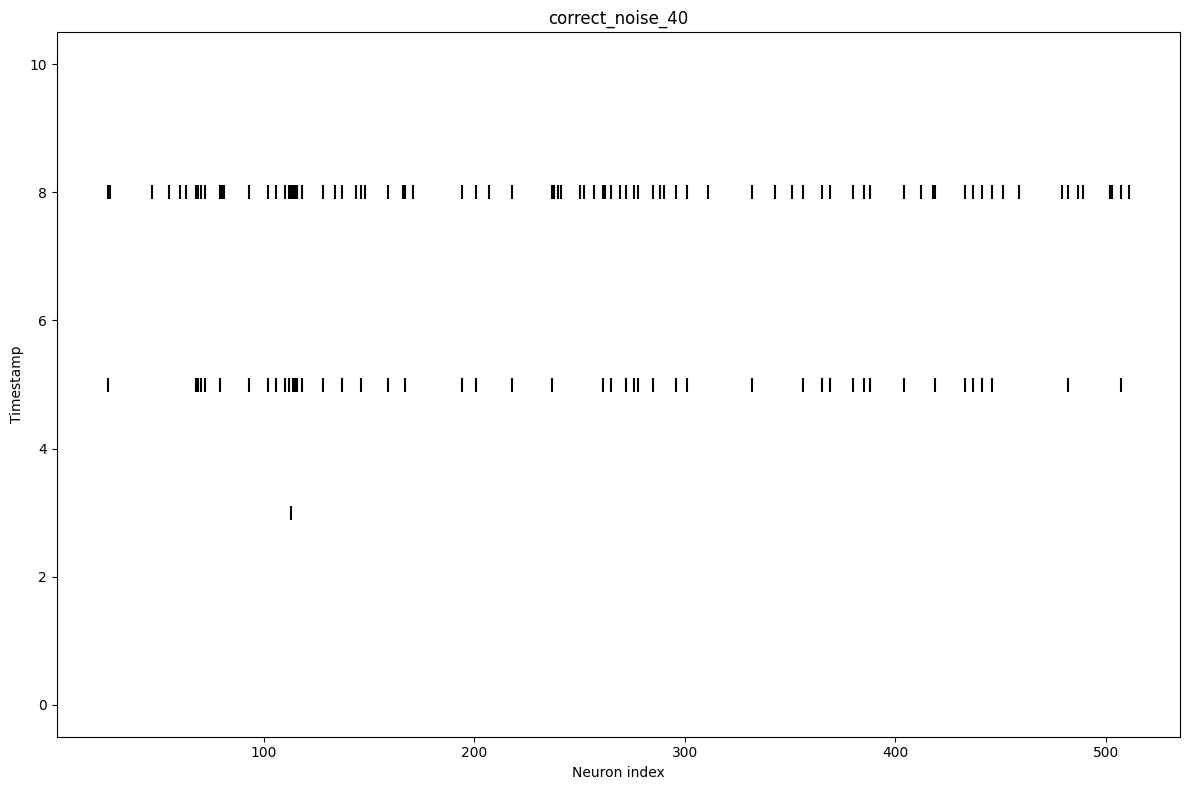

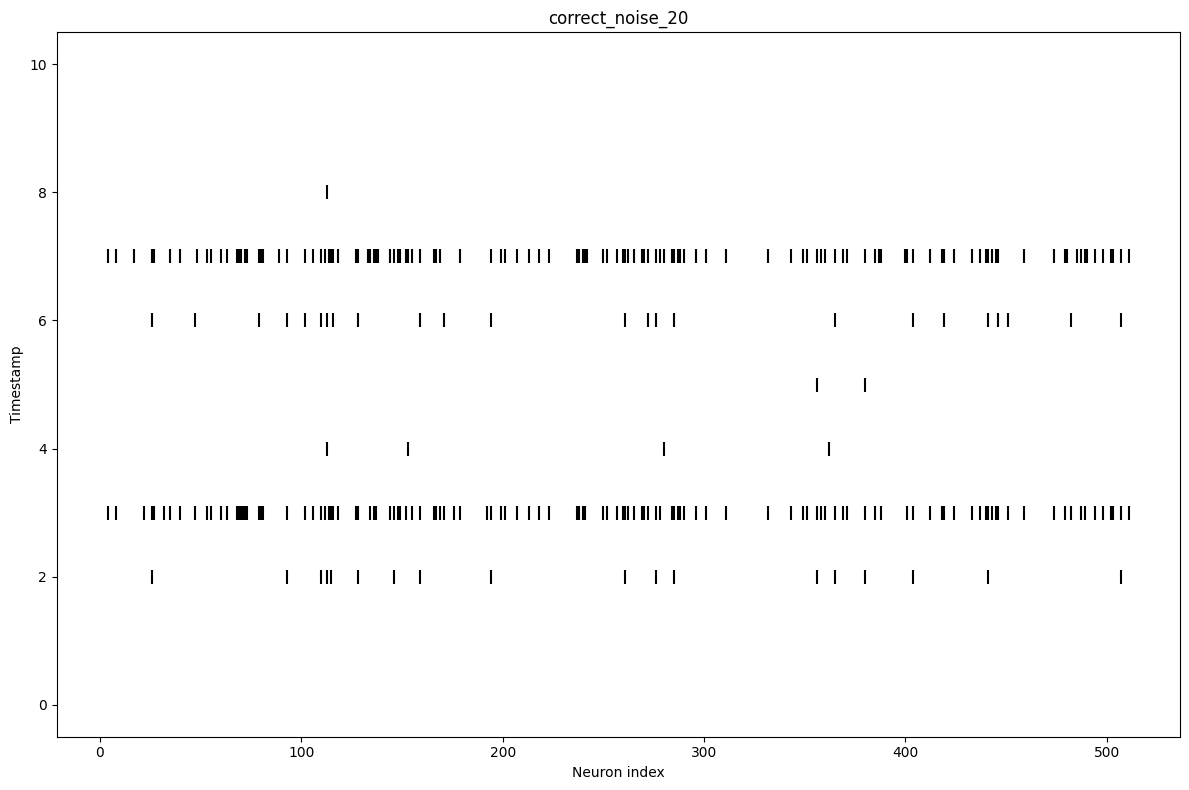

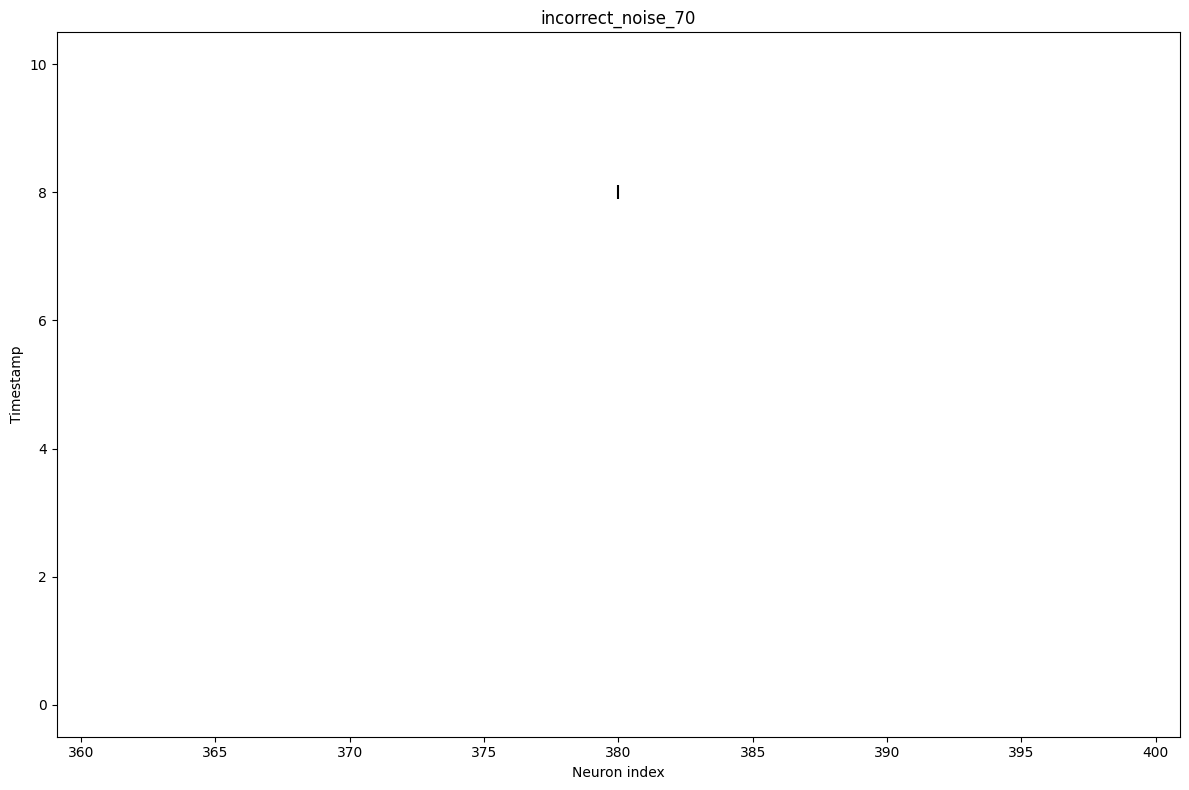

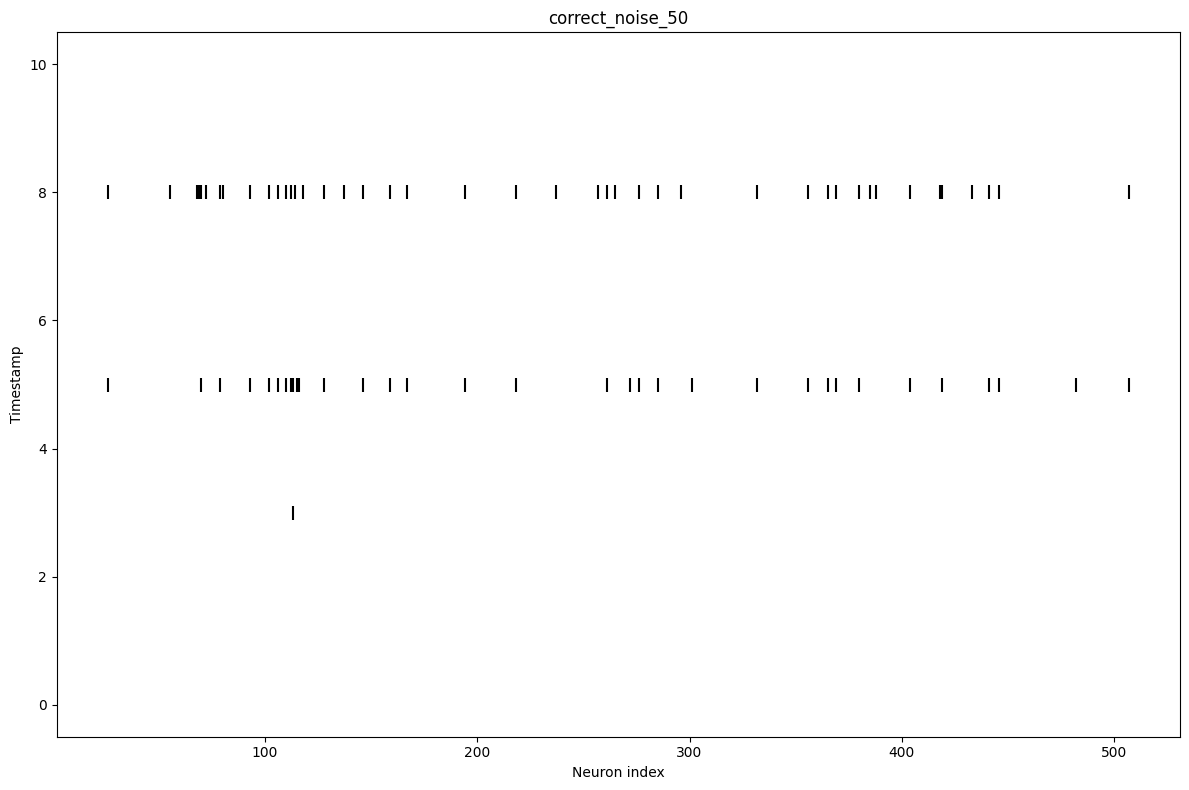

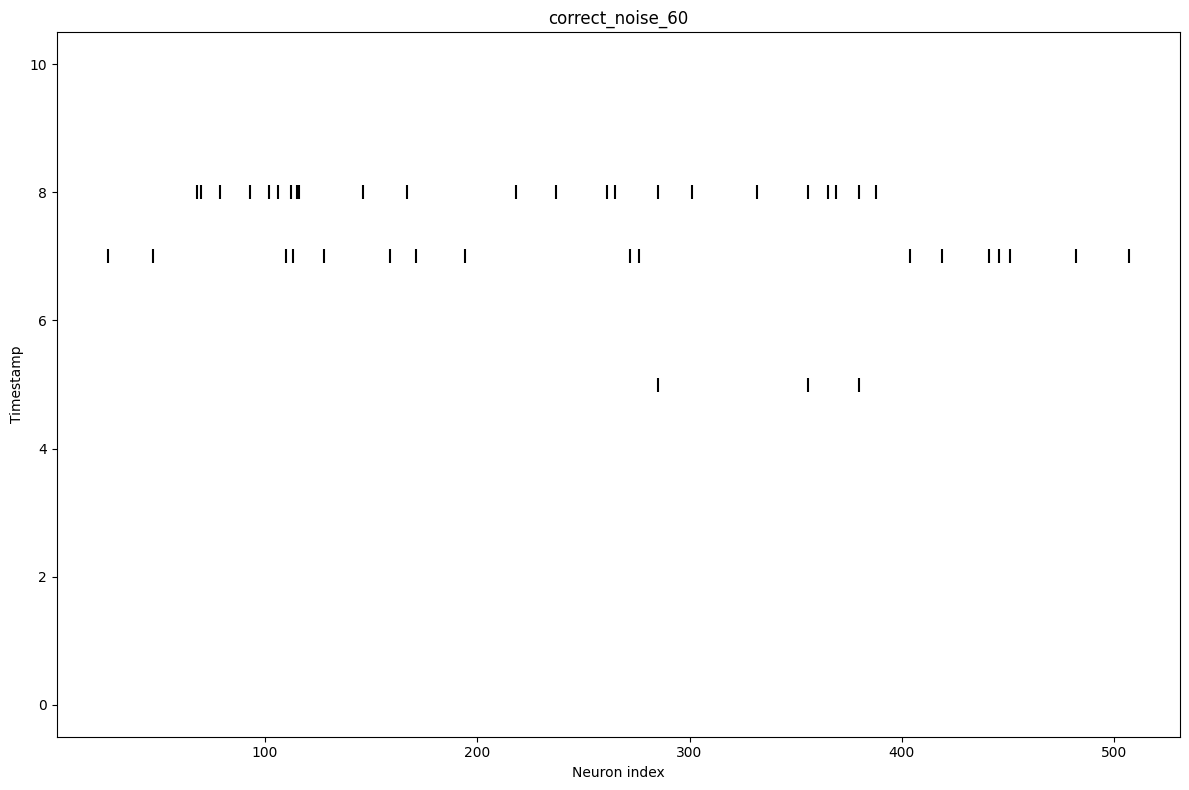

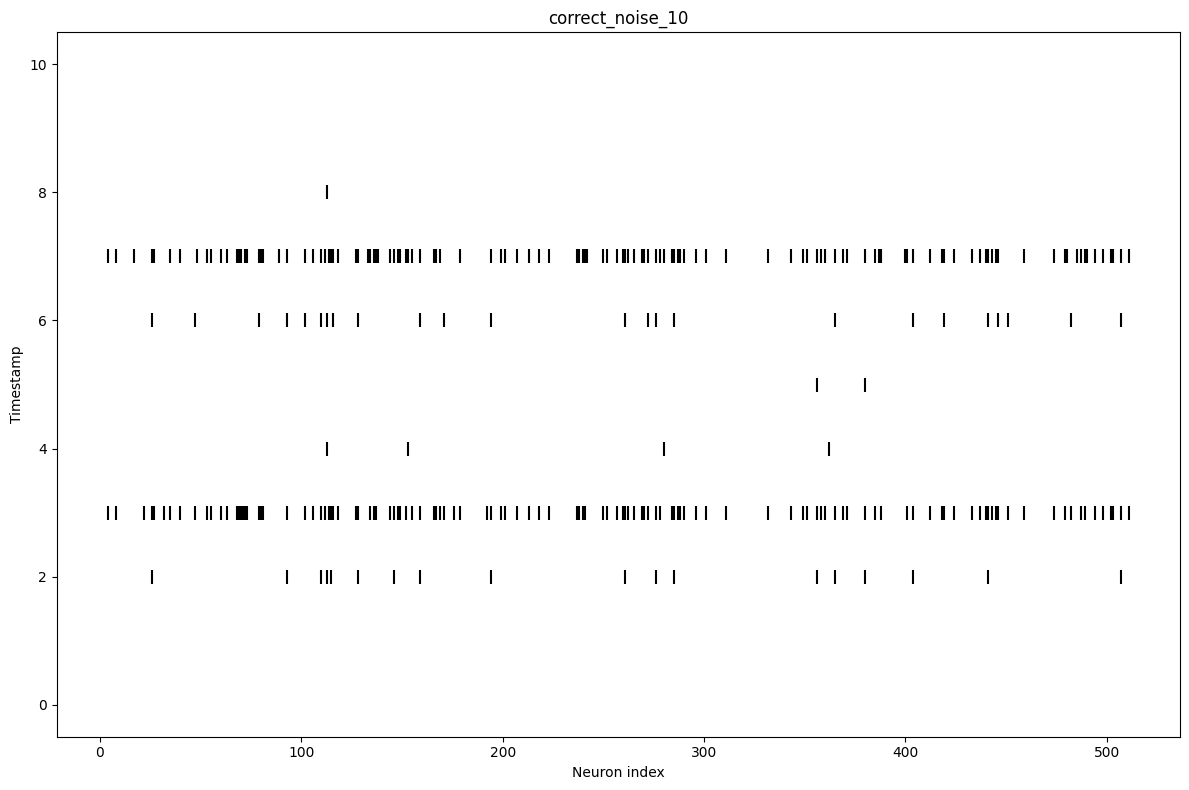

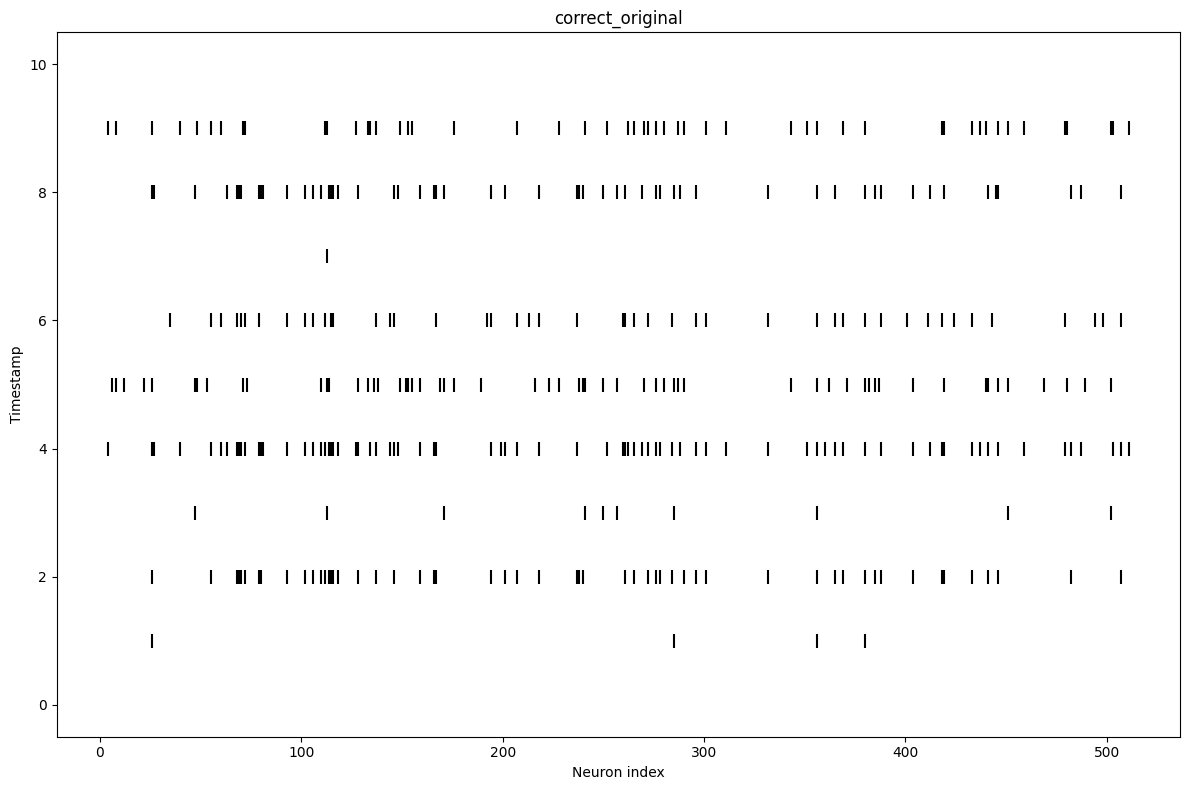

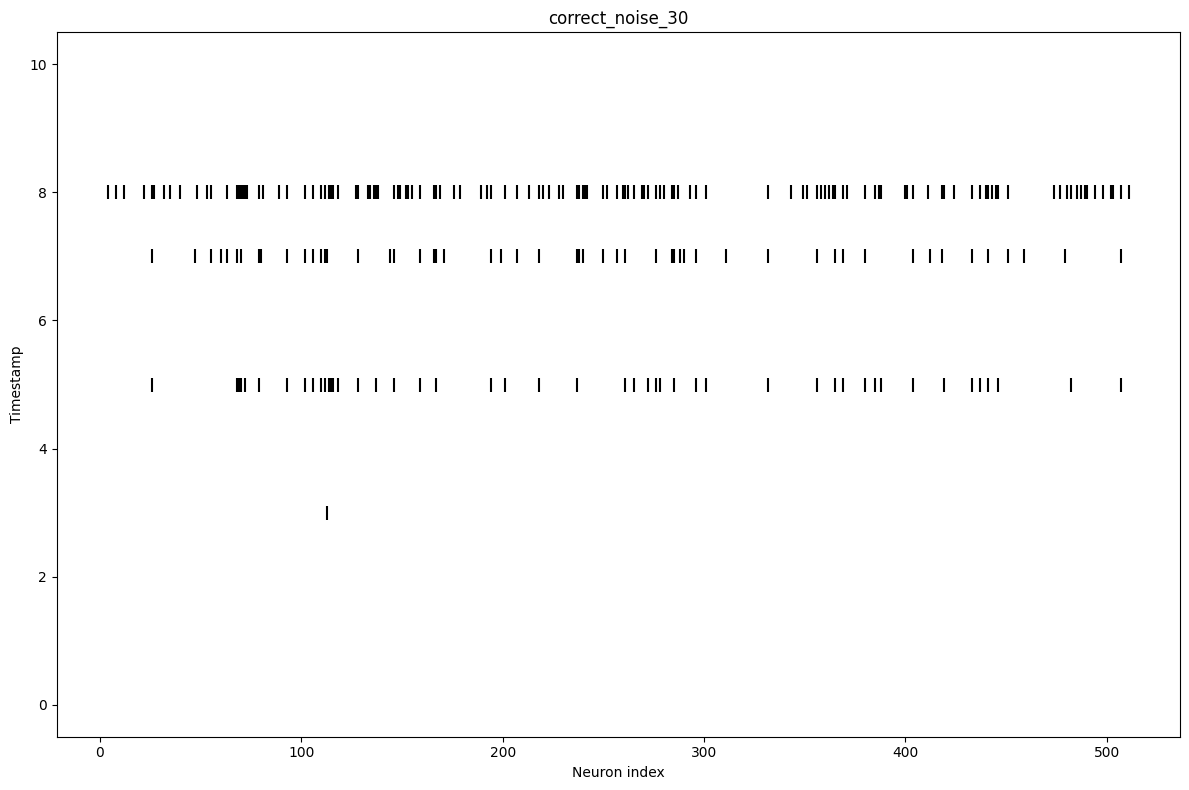

In [43]:
for label, spike_matrix in result_dict_raw.items():
    plot_spike_raster(spike_matrix, label)

Structured Data (first 5 singular values for each condition):
      Noise 10%  Noise 20%     Noise 30%     Noise 40%     Noise 50%  \
SV 1  15.498038  15.498038  1.308185e+01  1.077106e+01  8.091069e+00   
SV 2   5.355335   5.355335  6.277918e+00  3.874623e+00  3.256139e+00   
SV 3   3.412589   3.412589  4.414045e+00  9.856259e-01  9.654799e-01   
SV 4   2.554295   2.554295  9.844608e-01  2.423616e-16  2.301242e-16   
SV 5   1.964641   1.964641  2.140400e-16  0.000000e+00  0.000000e+00   

      Noise 60%   Original  Incorrect Noise 70%  
SV 1   4.841519  13.936629                  1.0  
SV 2   4.123106   8.168470                  0.0  
SV 3   1.599904   6.621866                  0.0  
SV 4   0.000000   4.720782                  0.0  
SV 5   0.000000   3.423036                  0.0  


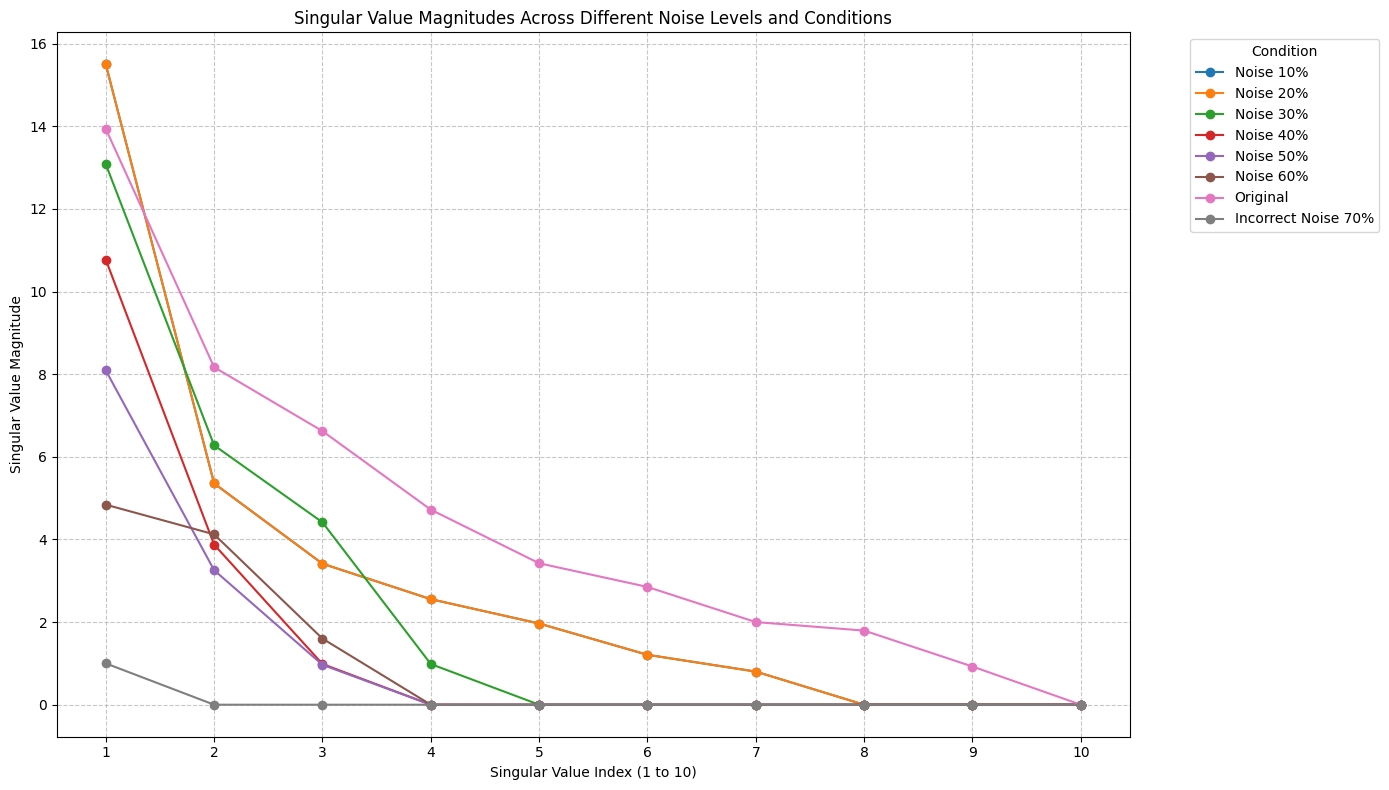

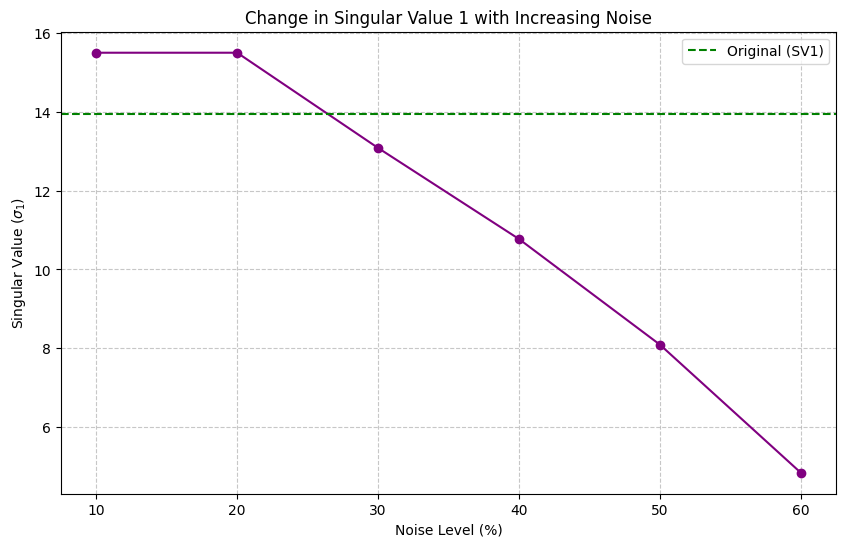

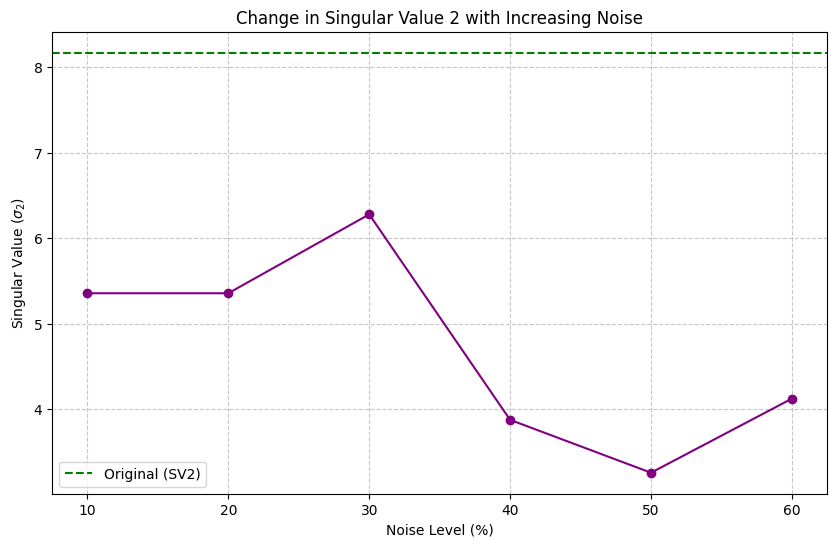

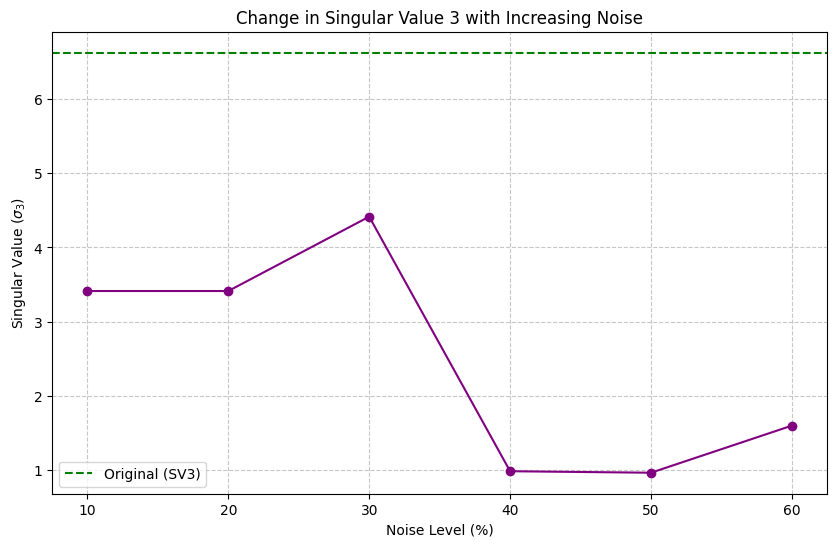

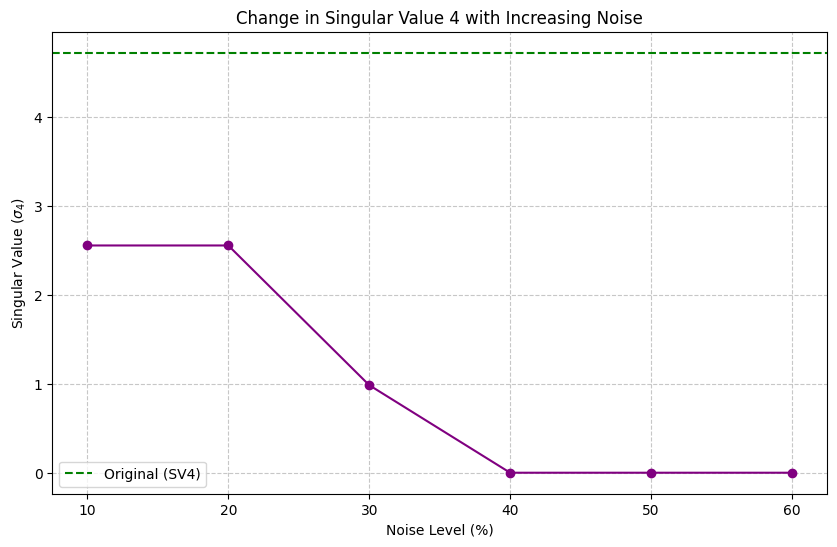

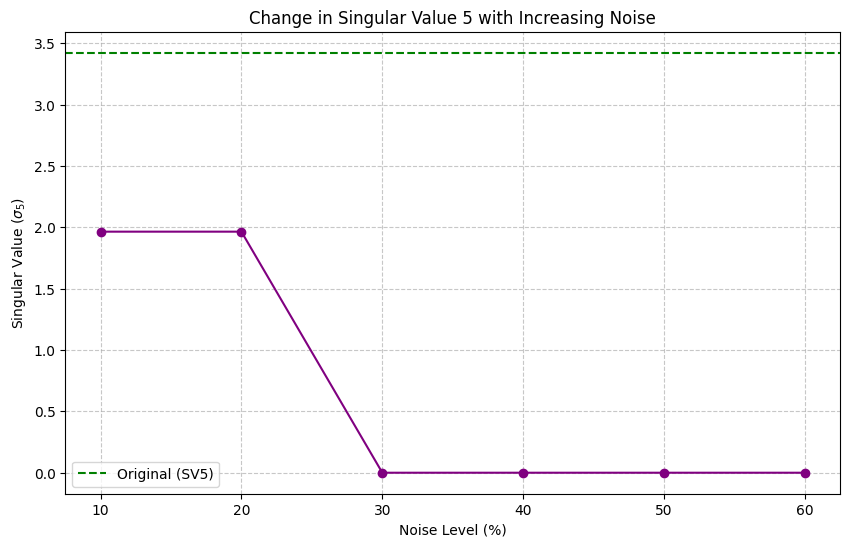

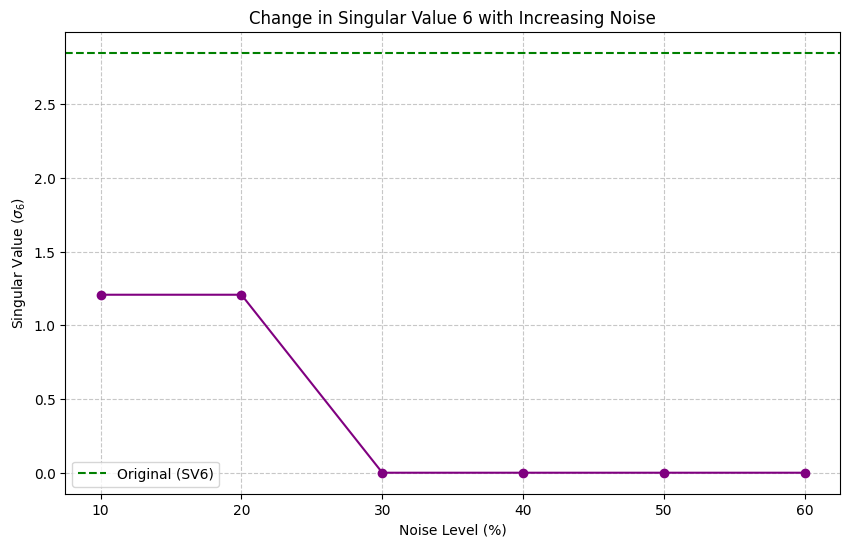

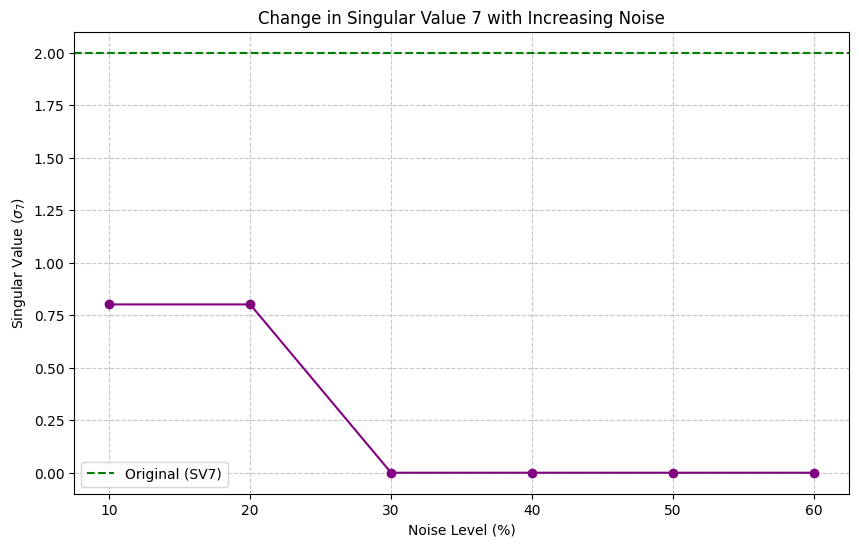

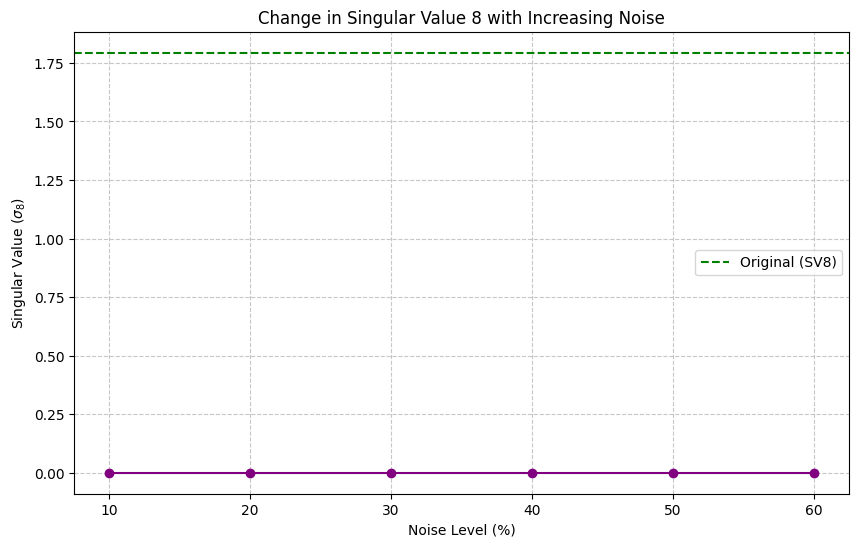


--- Explained Variance Ratio for Each Singular Value ---
correct_noise_40: [87.89 11.37  0.74]% (top 3 SVs)
correct_noise_20: [81.98  9.79  3.97]% (top 3 SVs)
incorrect_noise_70: [100.   0.   0.]% (top 3 SVs)
correct_noise_50: [85.02 13.77  1.21]% (top 3 SVs)
correct_noise_60: [54.51 39.53  5.95]% (top 3 SVs)
correct_noise_10: [81.98  9.79  3.97]% (top 3 SVs)
correct_original: [54.71 18.8  12.35]% (top 3 SVs)
correct_noise_30: [74.08 17.06  8.43]% (top 3 SVs)

Contribution of the first singular value to total variance:
            Condition  SV1_Contribution
2  incorrect_noise_70          1.000000
0    correct_noise_40          0.878908
3    correct_noise_50          0.850200
1    correct_noise_20          0.819758
5    correct_noise_10          0.819758
7    correct_noise_30          0.740843
6    correct_original          0.547126
4    correct_noise_60          0.545123

--- Effective Rank (Singular Values > 0.1) ---
correct_noise_40: 3
correct_noise_20: 7
incorrect_noise_70: 1
corr

In [44]:
svd_results_processed = {} 
noise_levels = []
original_svd_values = None
incorrect_svd_values = None

for key, value_dict in result_dict_singular.items():
    singular_values_array = value_dict["singular_values"]

    if 'original' in key:
        original_svd_values = singular_values_array
    elif 'incorrect' in key:
        incorrect_svd_values = singular_values_array
        incorrect_noise_level = int(key.split('_')[-1])
    else:
        try:
            noise_percent = int(key.split('_')[-1])
            noise_levels.append(noise_percent)
            svd_results_processed[noise_percent] = singular_values_array
        except ValueError:
            print(f"Could not parse noise level from key: {key}")

noise_levels.sort()

df_svd = pd.DataFrame(index=[f'SV {i+1}' for i in range(10)])

for level in noise_levels:
    df_svd[f'Noise {level}%'] = svd_results_processed[level]

if original_svd_values is not None:
    df_svd['Original'] = original_svd_values
if incorrect_svd_values is not None:
    df_svd[f'Incorrect Noise {incorrect_noise_level}%'] = incorrect_svd_values

print("Structured Data (first 5 singular values for each condition):")
print(df_svd.head())

# PLOT SV FOR NOISE LEVELS

plt.figure(figsize=(14, 8))

for col in df_svd.columns:
    plt.plot(range(1, 11), df_svd[col], marker='o', label=col)

plt.xlabel('Singular Value Index (1 to 10)')
plt.ylabel('Singular Value Magnitude')
plt.title('Singular Value Magnitudes Across Different Noise Levels and Conditions')
plt.xticks(range(1, 11))
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


def plot_sv_trend(sv_index, sv_data_dict, noise_lvls, original_data=None, incorrect_data=None):
    plt.figure(figsize=(10, 6))
    sv_values = [sv_data_dict[level][sv_index] for level in noise_lvls]
    plt.plot(noise_lvls, sv_values, marker='o', linestyle='-', color='purple')
    if original_data is not None:
        plt.axhline(y=original_data[sv_index], color='green', linestyle='--', label=f'Original (SV{sv_index+1})')
    if incorrect_data is not None and 80 in noise_lvls:
        plt.plot(80, incorrect_data[sv_index], marker='x', color='red', markersize=10, label=f'Incorrect Noise 80% (SV{sv_index+1})')
    plt.xlabel('Noise Level (%)')
    plt.ylabel(f'Singular Value ($\sigma_{sv_index+1}$)')
    plt.title(f'Change in Singular Value {sv_index+1} with Increasing Noise')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Plotting some first singular values across noise levels
for sv_index in range(len(df_svd.columns)):
    plot_sv_trend(sv_index, svd_results_processed, noise_levels, 
                  original_data=original_svd_values, 
                  incorrect_data=incorrect_svd_values if 'incorrect' in df_svd.columns else None)

# Percentage of total variance explained by the first few singular values
total_variance = {}
for key, value_dict in result_dict_singular.items():
    total_variance[key] = np.sum(value_dict["singular_values"]**2)

explained_variance_ratio = {}
for key, value_dict in result_dict_singular.items():
    s_values = value_dict["singular_values"]
    explained_variance_ratio[key] = s_values**2 / np.sum(s_values**2)

print("\n--- Explained Variance Ratio for Each Singular Value ---")
for key, ratio_array in explained_variance_ratio.items():
    print(f"{key}: {np.round(ratio_array[:3]*100, 2)}% (top 3 SVs)")

df_first_sv_contribution = pd.DataFrame(
    {'Condition': list(explained_variance_ratio.keys()),
     'SV1_Contribution': [ratio[0] for ratio in explained_variance_ratio.values()]}
)
print("\nContribution of the first singular value to total variance:")
print(df_first_sv_contribution.sort_values('SV1_Contribution', ascending=False))

threshold = 0.1 
effective_ranks = {key: np.sum(value_dict["singular_values"] > threshold) for key, value_dict in result_dict_singular.items()}
print(f"\n--- Effective Rank (Singular Values > {threshold}) ---")
for key, rank in effective_ranks.items():
    print(f"{key}: {rank}")

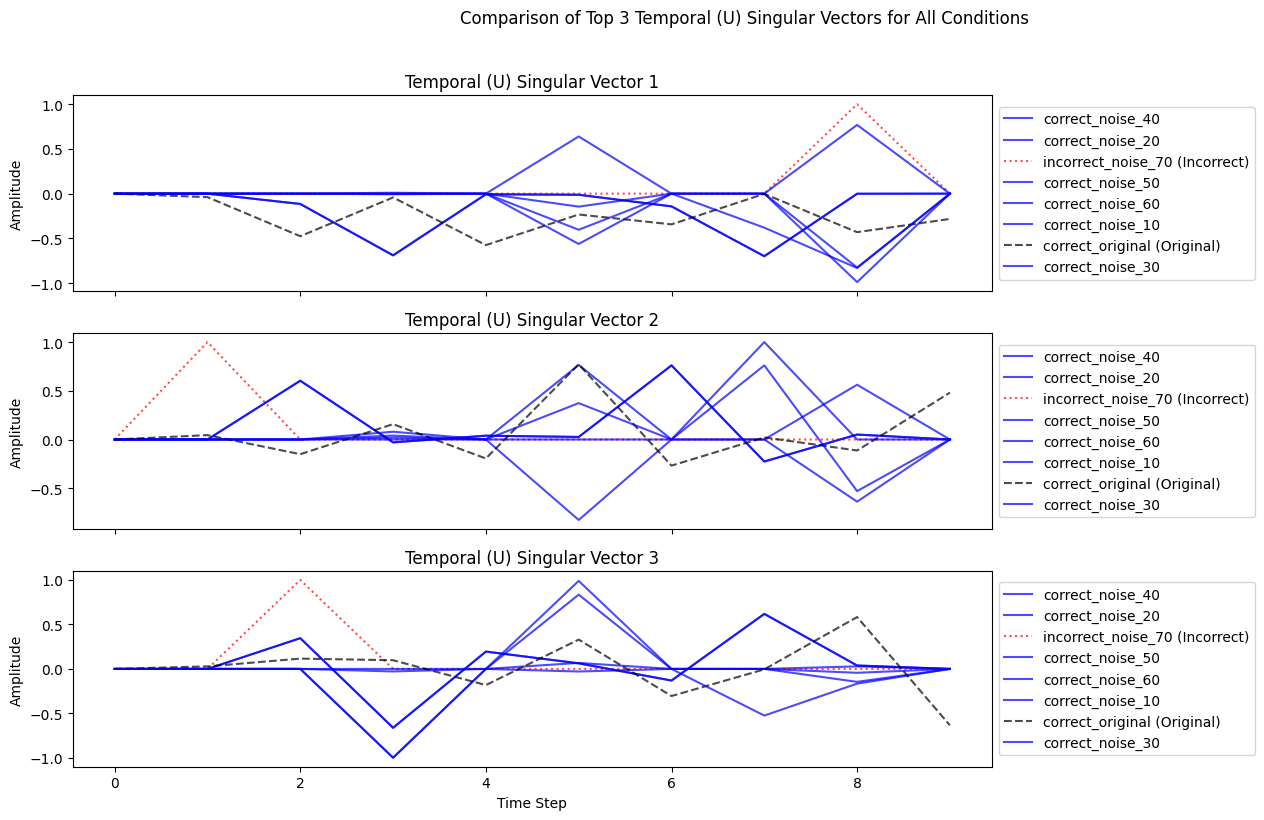

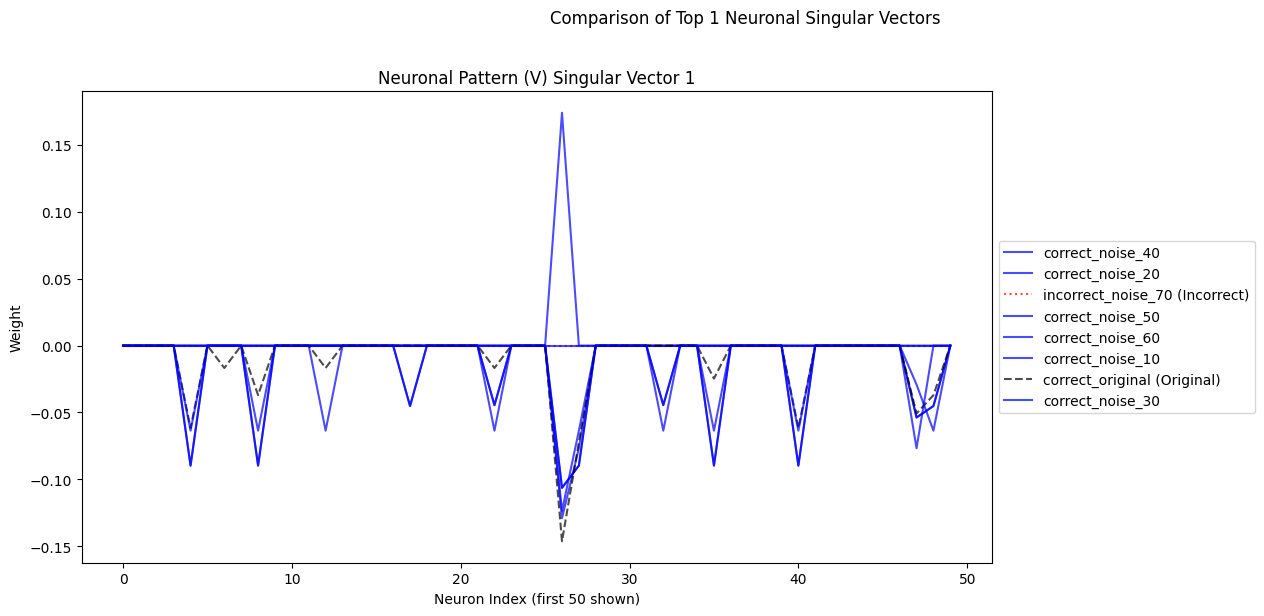


--- Cosine Similarities of Singular Vectors to 'Original' Condition ---

--- Left Singular Vectors (Temporal Patterns) ---
SV 1 (U):
  correct_noise_40: 0.488
  correct_noise_20: 0.143
  incorrect_noise_70: -0.431
  correct_noise_50: -0.481
  correct_noise_60: 0.460
  correct_noise_10: 0.143
  correct_noise_30: 0.454
SV 2 (U):
  correct_noise_40: -0.695
  correct_noise_20: -0.298
  incorrect_noise_70: 0.045
  correct_noise_50: 0.676
  correct_noise_60: 0.021
  correct_noise_10: -0.298
  correct_noise_30: 0.368
SV 3 (U):
  correct_noise_40: -0.091
  correct_noise_20: 0.020
  incorrect_noise_70: 0.116
  correct_noise_50: -0.100
  correct_noise_60: 0.242
  correct_noise_10: 0.020
  correct_noise_30: 0.179

--- Right Singular Vectors (Neuronal Patterns) ---
SV 1 (V):
  correct_noise_40: 0.948
  correct_noise_20: 0.881
  incorrect_noise_70: -0.171
  correct_noise_50: -0.840
  correct_noise_60: 0.620
  correct_noise_10: 0.881
  correct_noise_30: 0.911
SV 2 (V):
  correct_noise_40: 0.276
  c

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine



u_matrices = {}
v_matrices = {} 
conditions_list = [] 
for key, value_dict in result_dict_singular.items():
    u_matrices[key] = value_dict["left_singular_vectors"]
    v_matrices[key] = value_dict["right_singular_vectors"].T 
    conditions_list.append(key)

# Separate original, correct noise, and incorrect noise for easier plotting
original_key = next((k for k in conditions_list if 'original' in k), None)
incorrect_key = next((k for k in conditions_list if 'incorrect' in k), None)

correct_noise_keys = sorted([k for k in conditions_list if 'correct_noise' in k], key=lambda x: int(x.split('_')[-1]))

# --- 2. Visualizing Top Singular Vectors ---

def plot_singular_vectors(vectors_dict, vector_type='Temporal (U)', num_vectors_to_plot=3, figure_title_suffix=""):
    """
    Plots the top N singular vectors for different conditions.
    Assumes vectors_dict contains 'U' or 'V' matrices.
    """
    plt.figure(figsize=(15, 8))
    vector_dim = vectors_dict[list(vectors_dict.keys())[0]].shape[0] 
    for i in range(num_vectors_to_plot):
        ax = plt.subplot(num_vectors_to_plot, 1, i + 1)
        ax.set_title(f'{vector_type} Singular Vector {i+1}')
        for cond_name, matrix in vectors_dict.items():
            if 'original' in cond_name:
                style = 'k--' 
                label_suffix = ' (Original)'
            elif 'incorrect' in cond_name:
                style = 'r:' 
                label_suffix = ' (Incorrect)'
            else:
                style = 'b-'
                label_suffix = ''

            label = f'{cond_name}{label_suffix}'
            ax.plot(range(vector_dim), matrix[:, i], style, label=label, alpha=0.7)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Amplitude')
        if i == num_vectors_to_plot - 1:
            ax.set_xlabel('Time Step' if vector_type == 'Temporal (U)' else 'Neuron Index')
        else:
            ax.set_xticklabels([]) 

    plt.suptitle(f'Comparison of Top {num_vectors_to_plot} {vector_type} Singular Vectors {figure_title_suffix}', y=1.02)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

plot_singular_vectors(u_matrices, vector_type='Temporal (U)', num_vectors_to_plot=3, figure_title_suffix="for All Conditions")


def plot_neuronal_patterns(v_matrices, num_vectors_to_plot=1):
    plt.figure(figsize=(15, 6))
    for i in range(num_vectors_to_plot):
        ax = plt.subplot(num_vectors_to_plot, 1, i + 1)
        ax.set_title(f'Neuronal Pattern (V) Singular Vector {i+1}')
        for cond_name, matrix in v_matrices.items():
            if 'original' in cond_name:
                style = 'k--'
                label_suffix = ' (Original)'
            elif 'incorrect' in cond_name:
                style = 'r:'
                label_suffix = ' (Incorrect)'
            else:
                style = 'b-'
                label_suffix = ''
            label = f'{cond_name}{label_suffix}'
            ax.plot(matrix[:50, i], style, label=label, alpha=0.7) 
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Weight')
        ax.set_xlabel('Neuron Index (first 50 shown)')
    plt.suptitle(f'Comparison of Top {num_vectors_to_plot} Neuronal Singular Vectors', y=1.02)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_neuronal_patterns(v_matrices, num_vectors_to_plot=1) 

if original_key is None:
    print("Warning: 'Original' condition not found for reference. Skipping cosine similarity.")
else:
    u_ref = u_matrices[original_key]
    v_ref = v_matrices[original_key]

    print("\n--- Cosine Similarities of Singular Vectors to 'Original' Condition ---")

    print("\n--- Left Singular Vectors (Temporal Patterns) ---")
    for i in range(3): # Compare top 3
        print(f"SV {i+1} (U):")
        for cond_name in conditions_list:
            if cond_name == original_key: continue
            u_current = u_matrices[cond_name]
            similarity = 1 - cosine(u_ref[:, i], u_current[:, i])
            print(f"  {cond_name}: {similarity:.3f}")

    print("\n--- Right Singular Vectors (Neuronal Patterns) ---")
    for i in range(3): # Compare top 3 
        print(f"SV {i+1} (V):")
        for cond_name in conditions_list:
            if cond_name == original_key: continue
            v_current = v_matrices[cond_name]
            similarity = 1 - cosine(v_ref[:, i], v_current[:, i])
            print(f"  {cond_name}: {similarity:.3f}")


--- 1. Population PSTHs ---


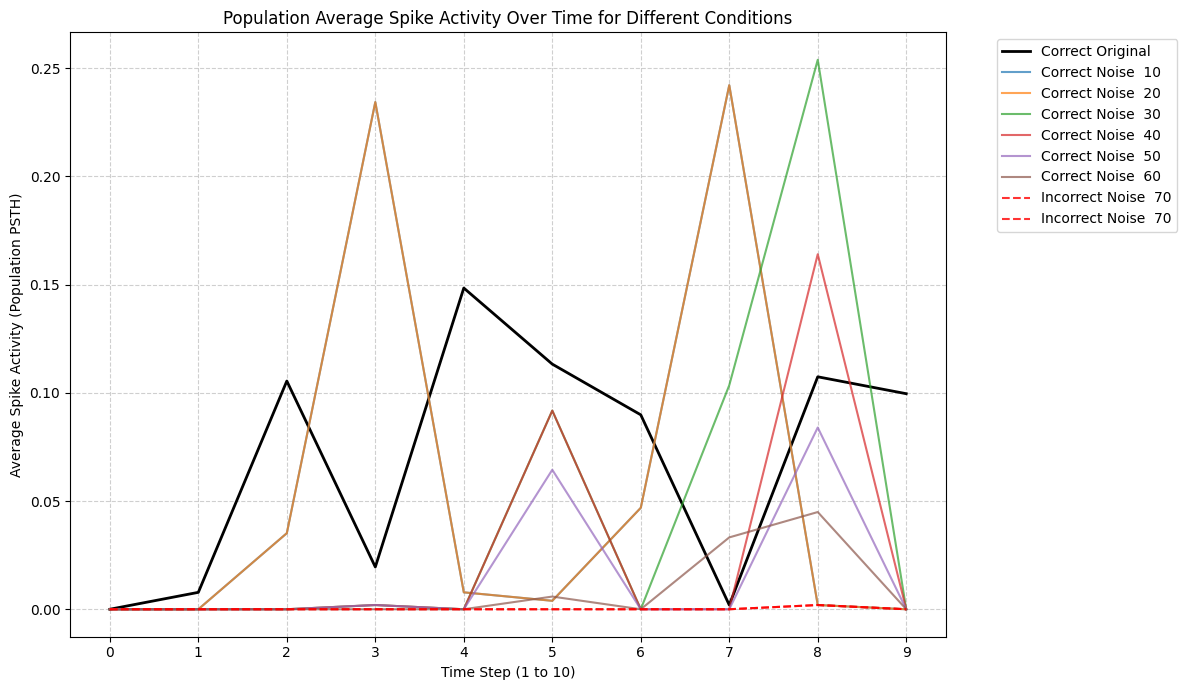


--- 2. Average Firing Rates ---

Overall Average Firing Rate per Neuron (across all timesteps):
  Correct Original: 0.069
  Correct Noise 10: 0.057
  Correct Noise 20: 0.057
  Correct Noise 30: 0.045
  Correct Noise 40: 0.026
  Correct Noise 50: 0.015
  Correct Noise 60: 0.008
  Incorrect Noise 70: 0.000


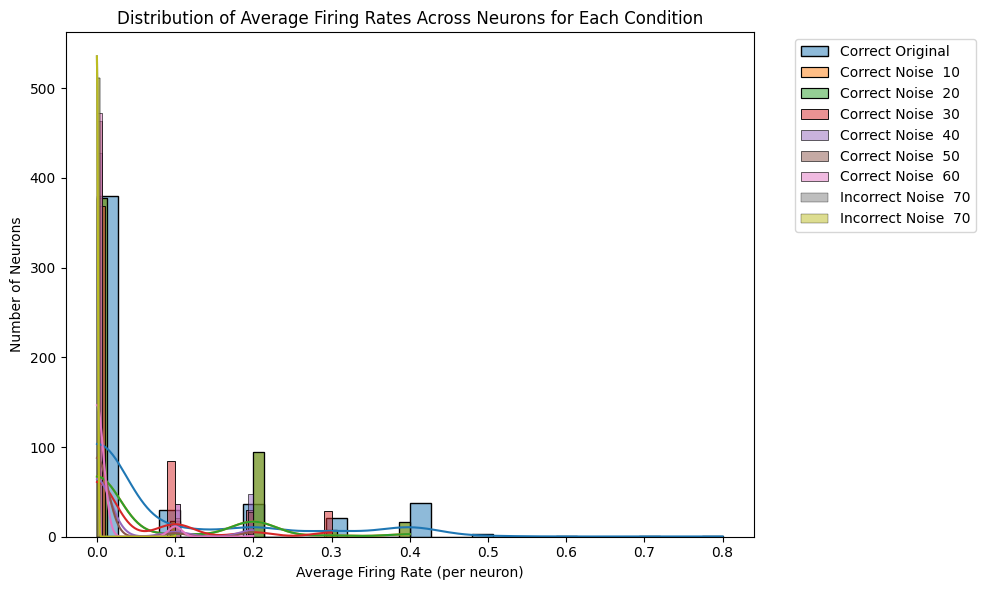


--- 3. Correlation Matrices ---
corr_matrix shape correct_original: (512, 512)
corr_matrix shape correct_noise_10: (512, 512)
corr_matrix shape correct_noise_20: (512, 512)
corr_matrix shape correct_noise_30: (512, 512)
corr_matrix shape correct_noise_40: (512, 512)
corr_matrix shape correct_noise_50: (512, 512)
corr_matrix shape correct_noise_60: (512, 512)
corr_matrix shape incorrect_noise_70: (512, 512)
corr_matrix shape incorrect_noise_70: (512, 512)


/home/szymon/code/PhD/spiking_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/szymon/code/PhD/spiking_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


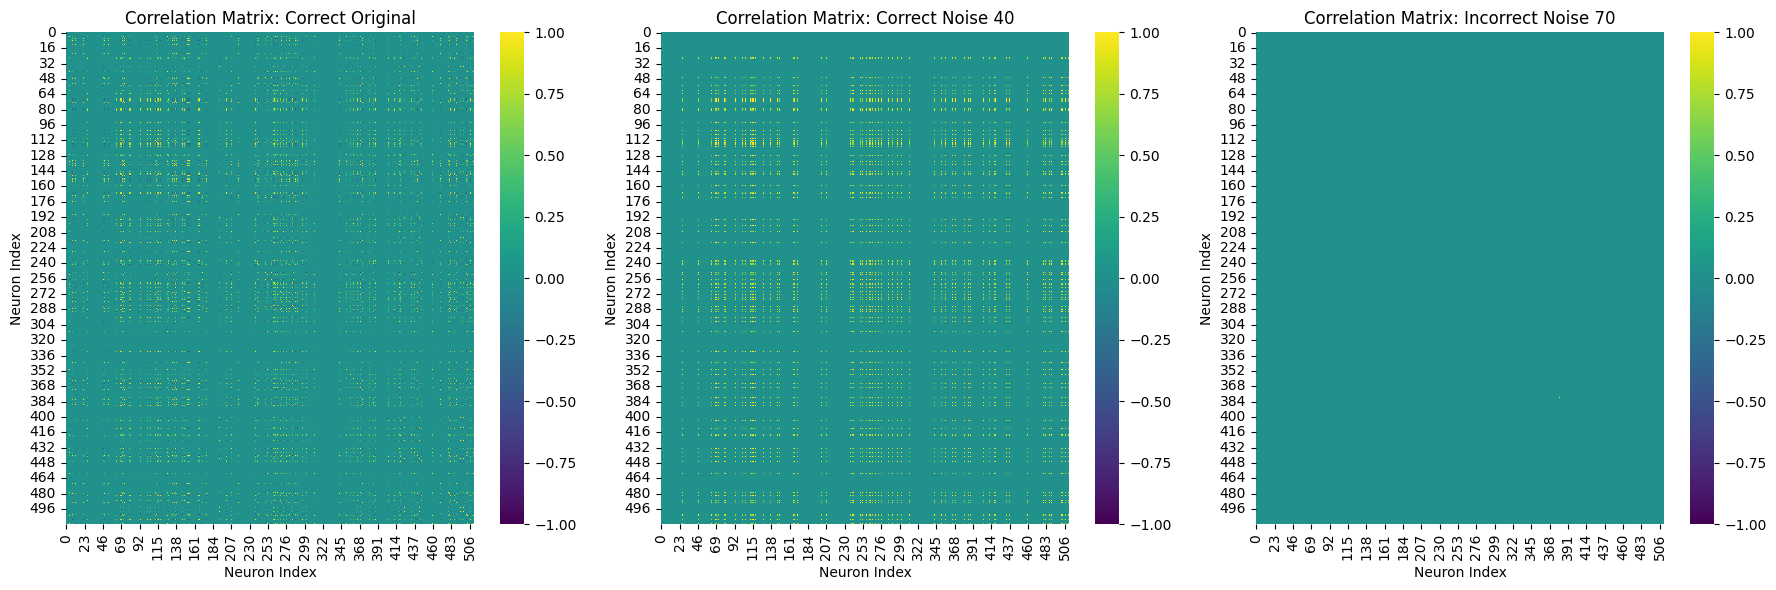


--- Differences in Correlation Matrices ---


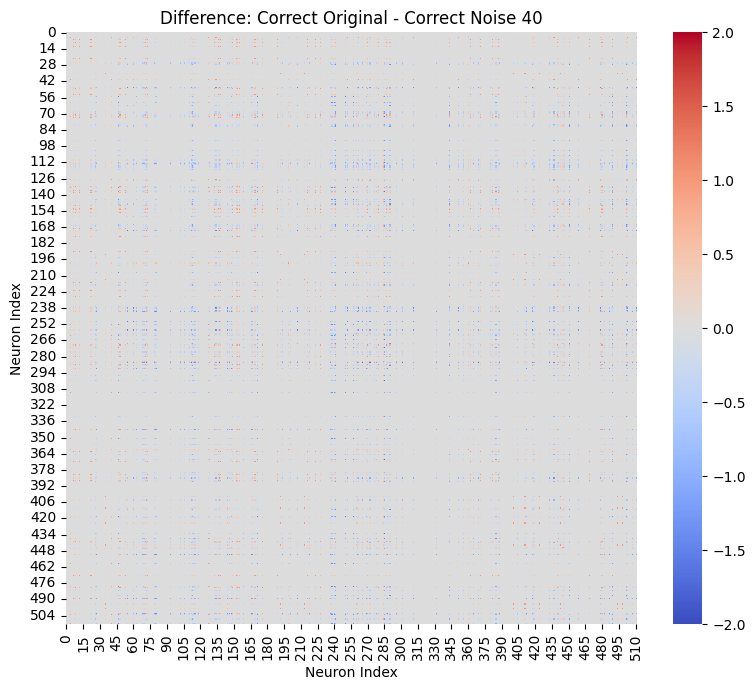

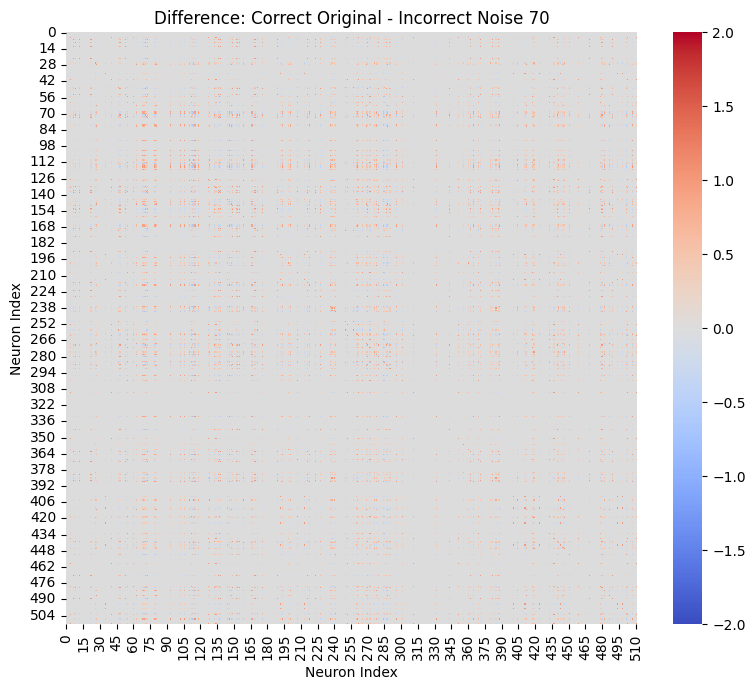

In [48]:
import seaborn as sns
condition_names = list(result_dict_raw.keys())
original_condition = next((k for k in condition_names if 'original' in k), None)
incorrect_condition = next((k for k in condition_names if 'incorrect' in k), None)
correct_noise_conditions = sorted(
    [k for k in condition_names if 'correct_noise' in k],
    key=lambda x: int(x.split('_')[-1])
)

plot_order = []
if original_condition:
    plot_order.append(original_condition)
plot_order.extend(correct_noise_conditions)
if incorrect_condition:
    plot_order.append(incorrect_condition)

print("\n--- 1. Population PSTHs ---")

plt.figure(figsize=(12, 7))
for cond_name in plot_order:
    spike_matrix = result_dict_raw[cond_name]
    population_psth = np.mean(spike_matrix, axis=1) 

    # Label formatting
    label = cond_name.replace('_', ' ').title()
    if 'noise' in cond_name:
        label = label.replace('Noise', 'Noise ') 
    if 'incorrect' in cond_name:
        plt.plot(range(10), population_psth, label=label, linestyle='--', color='red', alpha=0.8)
    elif 'original' in cond_name:
        plt.plot(range(10), population_psth, label=label, linewidth=2, color='black')
    else:
        plt.plot(range(10), population_psth, label=label, alpha=0.7)

plt.xlabel('Time Step (1 to 10)')
plt.ylabel('Average Spike Activity (Population PSTH)')
plt.title('Population Average Spike Activity Over Time for Different Conditions')
plt.xticks(range(10))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n--- 2. Average Firing Rates ---")

overall_avg_rates = {}
per_neuron_avg_rates_data = {}

for cond_name in plot_order:
    spike_matrix = result_dict_raw[cond_name]

    overall_avg_rates[cond_name] = np.mean(spike_matrix)

    per_neuron_avg_rates_data[cond_name] = np.mean(spike_matrix, axis=0)

print("\nOverall Average Firing Rate per Neuron (across all timesteps):")
for cond_name, rate in overall_avg_rates.items():
    print(f"  {cond_name.replace('_', ' ').title()}: {rate:.3f}")

plt.figure(figsize=(10, 6))
for cond_name in plot_order:
    label = cond_name.replace('_', ' ').title()
    if 'noise' in cond_name:
        label = label.replace('Noise', 'Noise ')
    sns.histplot(per_neuron_avg_rates_data[cond_name], kde=True, label=label, alpha=0.5, bins=30)

plt.xlabel('Average Firing Rate (per neuron)')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Average Firing Rates Across Neurons for Each Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n--- 3. Correlation Matrices ---")

correlation_matrices = {}
for cond_name in plot_order:
    spike_matrix = result_dict_raw[cond_name]

    corr_matrix = np.corrcoef(spike_matrix.T)
    corr_matrix[np.isnan(corr_matrix)] = 0 
    correlation_matrices[cond_name] = corr_matrix
    print(f"corr_matrix shape {cond_name}: {corr_matrix.shape}")
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

if original_condition:
    sns.heatmap(correlation_matrices[original_condition], ax=axes[0], cmap='viridis', cbar=True, vmin=-1, vmax=1)
    axes[0].set_title(f'Correlation Matrix: {original_condition.replace("_", " ").title()}')
    axes[0].set_xlabel('Neuron Index')
    axes[0].set_ylabel('Neuron Index')

sample_correct_noise_cond = 'correct_noise_40'
if sample_correct_noise_cond in correlation_matrices:
    sns.heatmap(correlation_matrices[sample_correct_noise_cond], ax=axes[1], cmap='viridis', cbar=True, vmin=-1, vmax=1)
    axes[1].set_title(f'Correlation Matrix: {sample_correct_noise_cond.replace("_", " ").title()}')
    axes[1].set_xlabel('Neuron Index')
    axes[1].set_ylabel('Neuron Index')

if incorrect_condition:
    sns.heatmap(correlation_matrices[incorrect_condition], ax=axes[2], cmap='viridis', cbar=True, vmin=-1, vmax=1)
    axes[2].set_title(f'Correlation Matrix: {incorrect_condition.replace("_", " ").title()}')
    axes[2].set_xlabel('Neuron Index')
    axes[2].set_ylabel('Neuron Index')

plt.tight_layout()
plt.show()


print("\n--- Differences in Correlation Matrices ---")

if original_condition and sample_correct_noise_cond in correlation_matrices:
    diff_orig_vs_noise = correlation_matrices[original_condition] - correlation_matrices[sample_correct_noise_cond]
    plt.figure(figsize=(8, 7))
    sns.heatmap(diff_orig_vs_noise, cmap='coolwarm', cbar=True, center=0, vmin=-2, vmax=2) 
    plt.title(f'Difference: {original_condition.replace("_", " ").title()} - {sample_correct_noise_cond.replace("_", " ").title()}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.tight_layout()
    plt.show()

if original_condition and incorrect_condition:
    diff_orig_vs_incorrect = correlation_matrices[original_condition] - correlation_matrices[incorrect_condition]
    plt.figure(figsize=(8, 7))
    sns.heatmap(diff_orig_vs_incorrect, cmap='coolwarm', cbar=True, center=0, vmin=-2, vmax=2)
    plt.title(f'Difference: {original_condition.replace("_", " ").title()} - {incorrect_condition.replace("_", " ").title()}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.tight_layout()
    plt.show()



--- 1. Quantitative Comparison using Matrix Norms ---
Reference Matrix: Correct Original
--------------------------------------------------
Condition                      | Frobenius Norm     | Max Abs Diff   
-----------------------------------------------------------------
Correct Original               | 0.0000             | N/A            
Correct Noise 10               | 100.0260           | 1.5345         
Correct Noise 20               | 100.0260           | 1.5345         
Correct Noise 30               | 97.5179            | 1.6667         
Correct Noise 40               | 67.7941            | 1.6667         
Correct Noise 50               | 59.8783            | 1.6667         
Correct Noise 60               | 62.3882            | 1.6667         
Incorrect Noise 70             | 63.7067            | 1.0000         


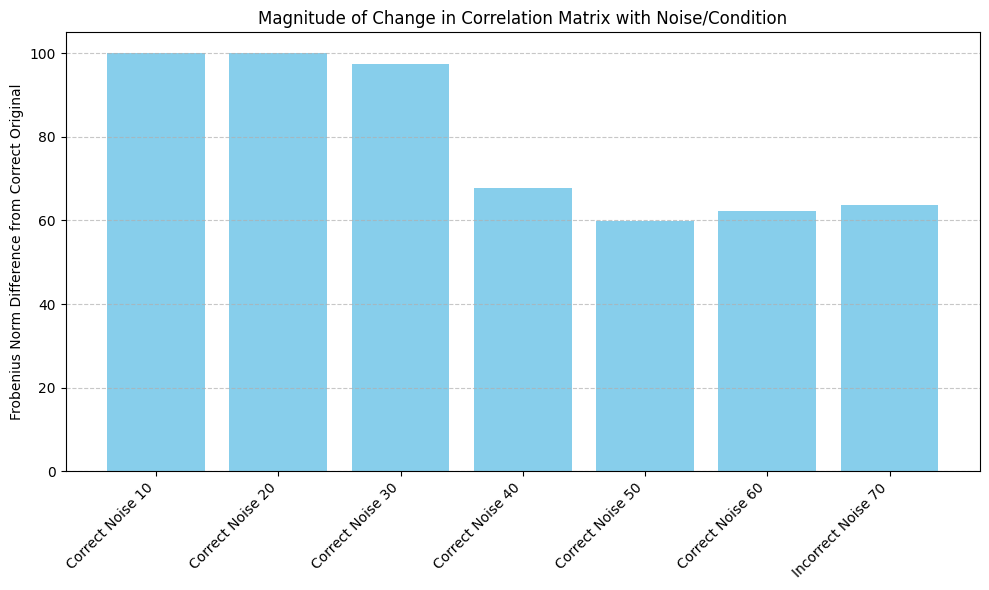


--- 2. Analysis of Connection Strengths ---

Connection Strength Metrics:
Condition                      | Mean Abs Corr     | Num Strong (>{threshold}) | % Strong (>{threshold})
------------------------------------------------------------------------------------------
Correct Original               | 0.0265            | 942                  | 0.72                %
Correct Noise 10               | 0.0529            | 4103                 | 3.14                %
Correct Noise 20               | 0.0529            | 4103                 | 3.14                %
Correct Noise 30               | 0.0523            | 3236                 | 2.47                %
Correct Noise 40               | 0.0220            | 1711                 | 1.31                %
Correct Noise 50               | 0.0068            | 481                  | 0.37                %
Correct Noise 60               | 0.0032            | 329                  | 0.25                %
Incorrect Noise 70             | 0.0000    

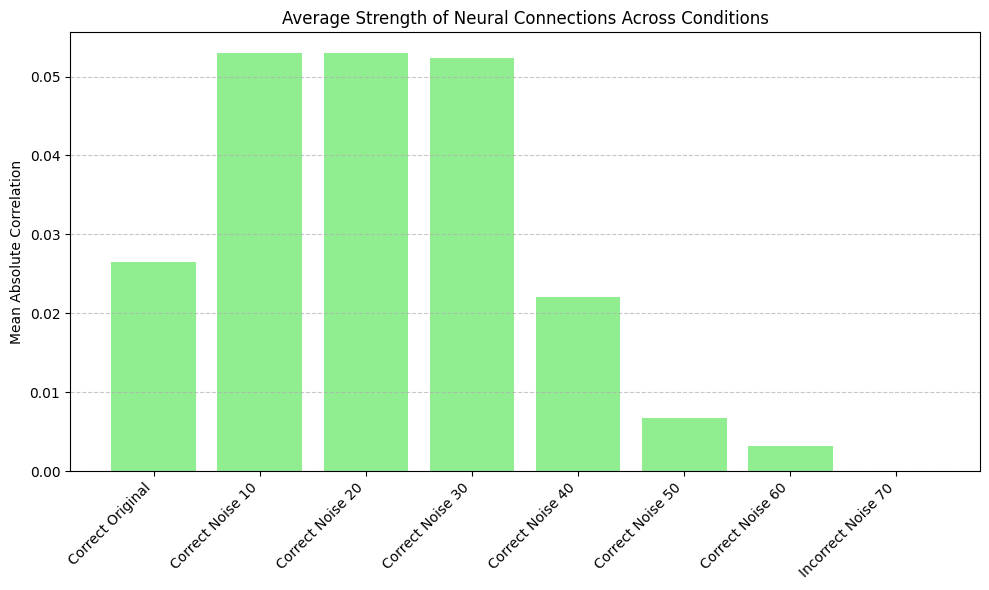


--- 3. Statistical Analysis of Element-wise Differences ---

Comparing Correct Original vs Incorrect Noise 70:
  Paired t-test on off-diagonal correlation elements:
    t-statistic: 42.527
    p-value: 0.000e+00
  Number of individual correlation pairs with an absolute change > 0.1: 8338
  Percentage of such pairs: 6.37%


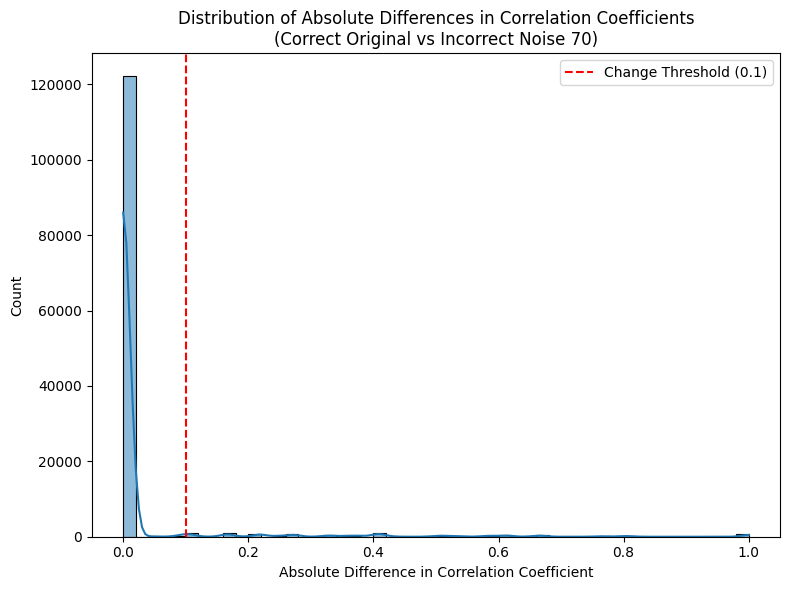

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel 
print("\n--- 1. Quantitative Comparison using Matrix Norms ---")

if original_condition:
    reference_matrix = correlation_matrices[original_condition]
    print(f"Reference Matrix: {original_condition.replace('_', ' ').title()}")
    print("-" * 50)

    norm_differences = {}
    for cond_name in plot_order:
        if cond_name == original_condition:
            norm_differences[cond_name] = 0.0 
            continue
        
        diff_matrix = reference_matrix - correlation_matrices[cond_name]
        
        frobenius_norm = np.linalg.norm(diff_matrix, 'fro')
        
        max_abs_diff = np.max(np.abs(diff_matrix))
        
        norm_differences[cond_name] = {'Frobenius Norm': frobenius_norm, 'Max Abs Diff': max_abs_diff}

    print(f"{'Condition':<30} | {'Frobenius Norm':<18} | {'Max Abs Diff':<15}")
    print("-" * 65)
    for cond, metrics in norm_differences.items():
        if isinstance(metrics, dict):
            print(f"{cond.replace('_', ' ').title():<30} | {metrics['Frobenius Norm']:<18.4f} | {metrics['Max Abs Diff']:<15.4f}")
        else:
            print(f"{cond.replace('_', ' ').title():<30} | {metrics:<18.4f} | {'N/A':<15}") # For original (0.0)

    plt.figure(figsize=(10, 6))
    conditions_for_plot = [k.replace('_', ' ').title() for k in plot_order if k != original_condition]
    frobenius_values = [norm_differences[k]['Frobenius Norm'] for k in plot_order if k != original_condition]

    plt.bar(conditions_for_plot, frobenius_values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Frobenius Norm Difference from {original_condition.replace("_", " ").title()}')
    plt.title('Magnitude of Change in Correlation Matrix with Noise/Condition')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("Cannot perform matrix norm analysis: 'Original' condition not found.")


print("\n--- 2. Analysis of Connection Strengths ---")

strength_metrics = {}
threshold = 0.8 # CHANGE THIS THRESHOLD

for cond_name in plot_order:
    matrix = correlation_matrices[cond_name].copy()
    
    np.fill_diagonal(matrix, 0)
    
    mean_abs_corr = np.mean(np.abs(matrix[np.triu_indices(matrix.shape[0], k=1)])) 
    
    num_strong_connections = np.sum(np.abs(matrix) > threshold) / 2 
    total_possible_connections = (matrix.shape[0] * (matrix.shape[0] - 1)) / 2
    perc_strong_connections = (num_strong_connections / total_possible_connections) * 100
    
    strength_metrics[cond_name] = {
        'Mean Abs Correlation': mean_abs_corr,
        'Num Strong Connections': num_strong_connections,
        'Perc Strong Connections': perc_strong_connections
    }

print("\nConnection Strength Metrics:")
print(f"{'Condition':<30} | {'Mean Abs Corr':<17} | {'Num Strong (>{threshold})':<20} | {'% Strong (>{threshold})':<20}")
print("-" * 90)
for cond, metrics in strength_metrics.items():
    print(f"{cond.replace('_', ' ').title():<30} | {metrics['Mean Abs Correlation']:<17.4f} | {metrics['Num Strong Connections']:<20.0f} | {metrics['Perc Strong Connections']:<20.2f}%")

plt.figure(figsize=(10, 6))
conditions_for_plot_bar = [k.replace('_', ' ').title() for k in plot_order]
mean_abs_corr_values = [strength_metrics[k]['Mean Abs Correlation'] for k in plot_order]

plt.bar(conditions_for_plot_bar, mean_abs_corr_values, color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Absolute Correlation')
plt.title('Average Strength of Neural Connections Across Conditions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\n--- 3. Statistical Analysis of Element-wise Differences ---")



if original_condition and incorrect_condition:
    # Get the upper triangle (excluding diagonal) of the correlation matrices
    # These are the pairwise correlations
    orig_corr_elements = correlation_matrices[original_condition][np.triu_indices(512, k=1)]
    incorrect_corr_elements = correlation_matrices[incorrect_condition][np.triu_indices(512, k=1)]

    # Paired t-test (assumes elements are paired and roughly normally distributed, which might not be true)
    # This is more for identifying *if* there's a difference in the distribution of correlations.
    t_stat, p_value = ttest_rel(orig_corr_elements, incorrect_corr_elements)

    print(f"\nComparing {original_condition.replace('_', ' ').title()} vs {incorrect_condition.replace('_', ' ').title()}:")
    print(f"  Paired t-test on off-diagonal correlation elements:")
    print(f"    t-statistic: {t_stat:.3f}")
    print(f"    p-value: {p_value:.3e}") # Use scientific notation for small p-values

    # Count elements with significant change (based on a magnitude threshold)
    difference_elements = np.abs(orig_corr_elements - incorrect_corr_elements)
    change_threshold = 0.1 # e.g., correlation changes by at least 0.1
    num_significant_changes = np.sum(difference_elements > change_threshold)
    perc_significant_changes = (num_significant_changes / len(difference_elements)) * 100

    print(f"  Number of individual correlation pairs with an absolute change > {change_threshold}: {num_significant_changes}")
    print(f"  Percentage of such pairs: {perc_significant_changes:.2f}%")

    # Plot histogram of the differences in correlation values
    plt.figure(figsize=(8, 6))
    sns.histplot(difference_elements, bins=50, kde=True)
    plt.axvline(x=change_threshold, color='r', linestyle='--', label=f'Change Threshold ({change_threshold})')
    plt.xlabel('Absolute Difference in Correlation Coefficient')
    plt.ylabel('Count')
    plt.title(f'Distribution of Absolute Differences in Correlation Coefficients\n({original_condition.replace("_", " ").title()} vs {incorrect_condition.replace("_", " ").title()})')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Cannot perform element-wise statistical analysis: 'Original' or 'Incorrect' condition not found.")

Mock `result_dict_raw` (with binned activity) created for ISI analysis.
Example matrix for 'correct_original' (first 3x3): 
[[12 20  9]
 [25 39 18]
 [17 27 12]]
Example data type: int64

--- Inter-Spike Interval (ISI) Analysis (for Binned Data) ---

ISI Summary Statistics (Overall per Condition):
Condition                 | Mean ISI   | Median ISI   | Std ISI    | CV ISI (Overall) | #ISIs    | #Neurons with ISIs  
--------------------------------------------------------------------------------------------------------------
Correct Original          | 1.12       | 1.00         | 0.33       | 0.29             | 4096     | 512                 
Correct Noise 10          | 1.11       | 1.00         | 0.31       | 0.28             | 4152     | 512                 
Correct Noise 20          | 1.10       | 1.00         | 0.30       | 0.27             | 4198     | 512                 
Correct Noise 30          | 1.10       | 1.00         | 0.31       | 0.28             | 4175     | 512         

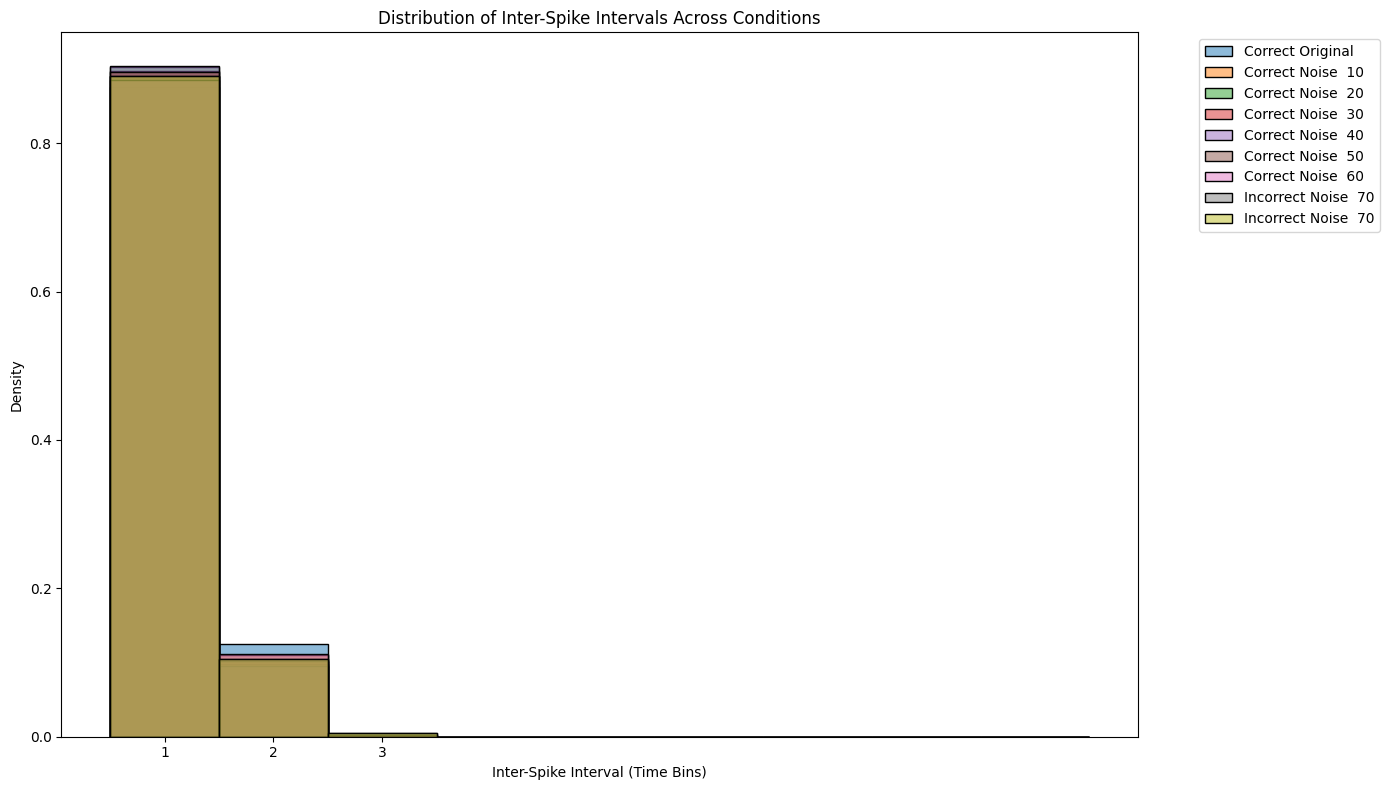


--- Visualizing Coefficient of Variation of ISI (CV_ISI) per neuron ---


/tmp/ipykernel_978865/1833431206.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='CV_ISI', data=df_cv, palette='viridis')


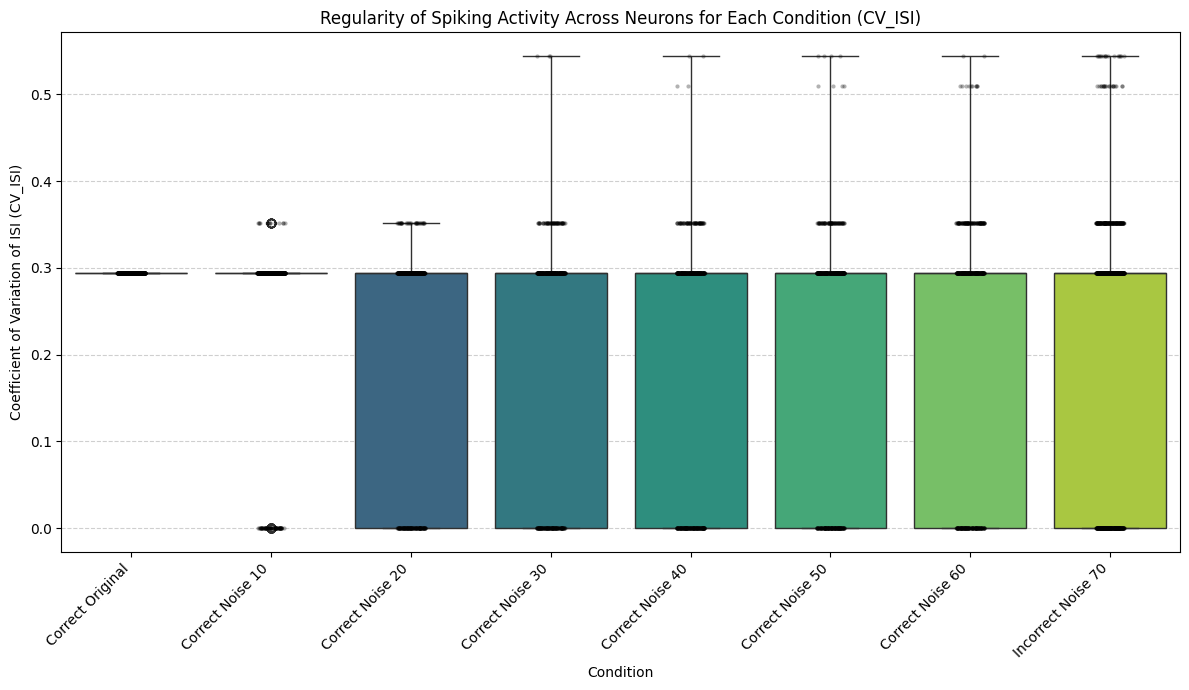


--- Summary of CV_ISI per Neuron (excluding NaNs) ---
                    mean_cv  std_cv  median_cv  q25_cv  q75_cv  perc_bursty
Condition                                                                  
Correct Noise 10       0.26    0.10       0.29    0.29    0.29          0.0
Correct Noise 20       0.22    0.13       0.29    0.00    0.29          0.0
Correct Noise 30       0.22    0.14       0.29    0.00    0.29          0.0
Correct Noise 40       0.20    0.15       0.29    0.00    0.29          0.0
Correct Noise 50       0.22    0.15       0.29    0.00    0.29          0.0
Correct Noise 60       0.23    0.15       0.29    0.00    0.29          0.0
Correct Original       0.29    0.00       0.29    0.29    0.29          0.0
Incorrect Noise 70     0.22    0.15       0.29    0.00    0.29          0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kstest # For Kolmogorov-Smirnov test

result_dict_raw = {}
conditions = {
    'correct_noise_40': 0.4, 'correct_noise_20': 0.2, 'correct_noise_50': 0.5,
    'correct_noise_60': 0.6,  'correct_noise_10': 0.1,
    'correct_original': 0.0, # Original implies no noise
    'correct_noise_30': 0.3, 'incorrect_noise_70': 0.7
}

np.random.seed(42) # For reproducibility of mock data

for cond_name, noise_level_sim in conditions.items():
    # Simulate a 10x512 spike matrix with some underlying structure
    # and then add noise, ensuring non-negative integer counts.
    
    # Base signal: some neurons fire at certain times
    base_time_pattern = np.sin(np.linspace(0, 2 * np.pi, 10) * 2) * 5 + 5 # A sinusoidal time course
    base_neuron_pattern = np.random.rand(512) * 3 + 1 # Different baseline activity for neurons
    
    # Create a base matrix (time x neurons)
    spike_matrix_base = np.outer(base_time_pattern, base_neuron_pattern) 
    
    # Add noise, scaled by the noise level
    noise_component = np.random.randn(10, 512) * noise_level_sim * 3 # Adjust noise amplitude
    
    # Combine, ensure non-negative, and round to integer counts for binning
    spike_matrix = np.round(np.maximum(0, spike_matrix_base + noise_component)).astype(int)
    
    result_dict_raw[cond_name] = spike_matrix

    # (Optional) Store in singular dict as you had before, just for consistency
    u, s, Vt = np.linalg.svd(spike_matrix)
    result_dict_singular[cond_name] = {"singular_values": s, "left_singular_vectors": u, "right_singular_vectors": Vt}

print("Mock `result_dict_raw` (with binned activity) created for ISI analysis.")
print(f"Example matrix for 'correct_original' (first 3x3): \n{result_dict_raw['correct_original'][:3, :3]}")
print(f"Example data type: {result_dict_raw['correct_original'].dtype}")
# --- End of Mocking ---


# --- Parse conditions and sort them for consistent plotting ---
condition_names = list(result_dict_raw.keys())
original_condition = next((k for k in condition_names if 'original' in k), None)
incorrect_condition = next((k for k in condition_names if 'incorrect' in k), None)
correct_noise_conditions = sorted(
    [k for k in condition_names if 'correct_noise' in k],
    key=lambda x: int(x.split('_')[-1])
)

plot_order = []
if original_condition: plot_order.append(original_condition)
plot_order.extend(correct_noise_conditions)
if incorrect_condition: plot_order.append(incorrect_condition)


# --- Inter-Spike Interval (ISI) Analysis ---
print("\n--- Inter-Spike Interval (ISI) Analysis (for Binned Data) ---")

all_condition_isis = {} # Stores lists of all ISIs for each condition
cv_isis_per_neuron_condition = {} # Stores arrays of CV_ISIs (one per neuron) for each condition
isi_stats_per_condition = {} # Stores summary stats (mean, median, etc.)

for cond_name in plot_order:
    spike_matrix = result_dict_raw[cond_name] # This is your 10x512 matrix

    current_condition_isis = [] # All ISIs collected from all neurons in this condition
    current_condition_cv_isis = [] # CV_ISI for each individual neuron in this condition
    num_neurons_with_isis = 0 # Counter for neurons that have at least 2 spikes

    # Iterate through each neuron (column) in the spike_matrix
    for neuron_idx in range(spike_matrix.shape[1]):
        neuron_spike_train = spike_matrix[:, neuron_idx] # Activity for this neuron across 10 timesteps
        
        # Find time steps where neuron activity is > 0 (considered a spike/event)
        # np.nonzero()[0] gives the indices (time bins) of non-zero elements
        spike_times_bins = np.nonzero(neuron_spike_train > 0)[0]

        # Calculate ISIs (differences between consecutive spike times)
        if len(spike_times_bins) >= 2: # Need at least two spikes to compute an ISI
            isis = np.diff(spike_times_bins)
            current_condition_isis.extend(isis.tolist()) # Add to collection for condition-wide histogram
            
            # Calculate Coefficient of Variation (CV) of ISI for this neuron
            if np.mean(isis) > 0: # Avoid division by zero if all ISIs are 0
                cv_isi = np.std(isis) / np.mean(isis)
                current_condition_cv_isis.append(cv_isi)
            else:
                current_condition_cv_isis.append(np.nan) # Append NaN if mean ISI is 0 (e.g., all ISIs were 0)
            num_neurons_with_isis += 1
        else:
            # If neuron has 0 or 1 spike, it doesn't contribute to ISI stats or CV
            current_condition_cv_isis.append(np.nan) # Mark as NaN for later filtering

    all_condition_isis[cond_name] = np.array(current_condition_isis) # Convert to numpy array
    cv_isis_per_neuron_condition[cond_name] = np.array(current_condition_cv_isis) # Convert to numpy array

    # Calculate summary statistics for the collected ISIs for this condition
    if len(current_condition_isis) > 0:
        isi_stats_per_condition[cond_name] = {
            'Mean ISI': np.mean(current_condition_isis),
            'Median ISI': np.median(current_condition_isis),
            'Std ISI': np.std(current_condition_isis),
            'CV ISI (Overall)': np.std(current_condition_isis) / np.mean(current_condition_isis) if np.mean(current_condition_isis) > 0 else np.nan,
            'Num ISIs': len(current_condition_isis),
            'Neurons with ISIs': num_neurons_with_isis
        }
    else: # Case where no ISIs could be calculated for any neuron in the condition
        isi_stats_per_condition[cond_name] = {
            'Mean ISI': np.nan, 'Median ISI': np.nan, 'Std ISI': np.nan, 'CV ISI (Overall)': np.nan,
            'Num ISIs': 0, 'Neurons with ISIs': num_neurons_with_isis
        }

# Print ISI Summary Statistics
print("\nISI Summary Statistics (Overall per Condition):")
print(f"{'Condition':<25} | {'Mean ISI':<10} | {'Median ISI':<12} | {'Std ISI':<10} | {'CV ISI (Overall)':<16} | {'#ISIs':<8} | {'#Neurons with ISIs':<20}")
print("-" * 110)
for cond_name in plot_order:
    stats = isi_stats_per_condition[cond_name]
    print(f"{cond_name.replace('_', ' ').title():<25} | {stats['Mean ISI']:<10.2f} | {stats['Median ISI']:<12.2f} | {stats['Std ISI']:<10.2f} | {stats['CV ISI (Overall)']:<16.2f} | {stats['Num ISIs']:<8} | {stats['Neurons with ISIs']:<20}")


# --- Visualize ISI Distributions ---
print("\n--- Visualizing ISI Distributions (Histograms) ---")

plt.figure(figsize=(14, 8))
# Since ISIs are integers from 1 to 9, specific bins are better than kde
bin_edges = np.arange(0.5, 10.5, 1) # Bins centered on integers 1-9
max_isi_val = 0 # To determine x-axis limit
for cond_name in plot_order:
    isis = all_condition_isis[cond_name]
    if len(isis) > 0:
        label = cond_name.replace('_', ' ').title()
        if 'noise' in cond_name:
            label = label.replace('Noise', 'Noise ')
        sns.histplot(isis, bins=bin_edges, stat='density', alpha=0.5, label=label)
        if isis.size > 0:
            max_isi_val = max(max_isi_val, int(np.max(isis)))
    else:
        print(f"No ISIs to plot for {cond_name}")

plt.xlabel('Inter-Spike Interval (Time Bins)')
plt.ylabel('Density')
plt.title('Distribution of Inter-Spike Intervals Across Conditions')
plt.xticks(np.arange(1, max_isi_val + 1 if max_isi_val > 0 else 10)) # Ensure x-ticks cover observed range
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.0) # Histograms don't usually use grid
plt.tight_layout()
plt.show()


# --- Analyze and Visualize Coefficient of Variation of ISI (CV_ISI) per neuron ---
print("\n--- Visualizing Coefficient of Variation of ISI (CV_ISI) per neuron ---")

# Convert CV_ISI data to a DataFrame for easier plotting with seaborn
cv_data_for_plot = []
for cond_name in plot_order:
    cvs = cv_isis_per_neuron_condition[cond_name]
    # Filter out NaNs (neurons with 0 or 1 spike have undefined CV)
    cvs_filtered = cvs[~np.isnan(cvs)]
    for cv in cvs_filtered:
        cv_data_for_plot.append({'Condition': cond_name.replace('_', ' ').title(), 'CV_ISI': cv})

df_cv = pd.DataFrame(cv_data_for_plot)

if not df_cv.empty:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Condition', y='CV_ISI', data=df_cv, palette='viridis')
    # Add individual points to show density if needed
    sns.stripplot(x='Condition', y='CV_ISI', data=df_cv, color='black', size=3, alpha=0.3, jitter=True) 
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Condition')
    plt.ylabel('Coefficient of Variation of ISI (CV_ISI)')
    plt.title('Regularity of Spiking Activity Across Neurons for Each Condition (CV_ISI)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Quantitative summary of CV_ISI per neuron
    print("\n--- Summary of CV_ISI per Neuron (excluding NaNs) ---")
    cv_summary_per_neuron = df_cv.groupby('Condition')['CV_ISI'].agg(
        mean_cv='mean', 
        std_cv='std', 
        median_cv='median', 
        q25_cv=lambda x: x.quantile(0.25),
        q75_cv=lambda x: x.quantile(0.75),
        perc_bursty=lambda x: np.sum(x > 1) / len(x) * 100 if len(x) > 0 else np.nan # Percentage of neurons with CV > 1 (bursty)
    )
    print(cv_summary_per_neuron.round(2))
else:
    print("No valid ISI data to compute CV_ISI per neuron (perhaps too few spikes/timesteps per neuron for meaningful intervals).")


